In [1]:
import torch
import matplotlib.pyplot as plot
import numpy
from sklearn.datasets import make_moons

In [2]:
# Set random seeds
torch.manual_seed(42)
numpy.random.seed(42)

In [3]:
x, y = make_moons(n_samples=200, noise=0.1)

In [4]:
y_torch = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot_torch = torch.scatter(torch.zeros((200, 2)), 1, y_torch, 1)

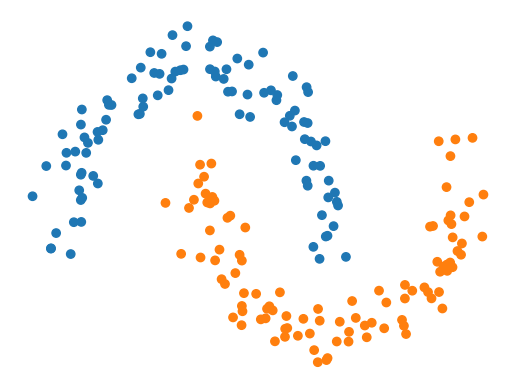

In [5]:
c = ["#1f77b4" if y_torch == 0 else "#ff7f0e" for y_torch in y]  # colours for each class
plot.axis("off")
plot.scatter(x[:, 0], x[:, 1], c=c)
plot.show()

In [6]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 95.2 MB/s eta 0:00:00


In [7]:
import pennylane as qml

In [8]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [9]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

In [10]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Creating a hybrid model

1. a 2-neuron fully connected classical layer
2. our 2-qubit QNode converted into a layer
3. another 2-neuron fully connected classical layer
4. a softmax activation to convert to a probability vector

A diagram of the model can be seen in the figure below.

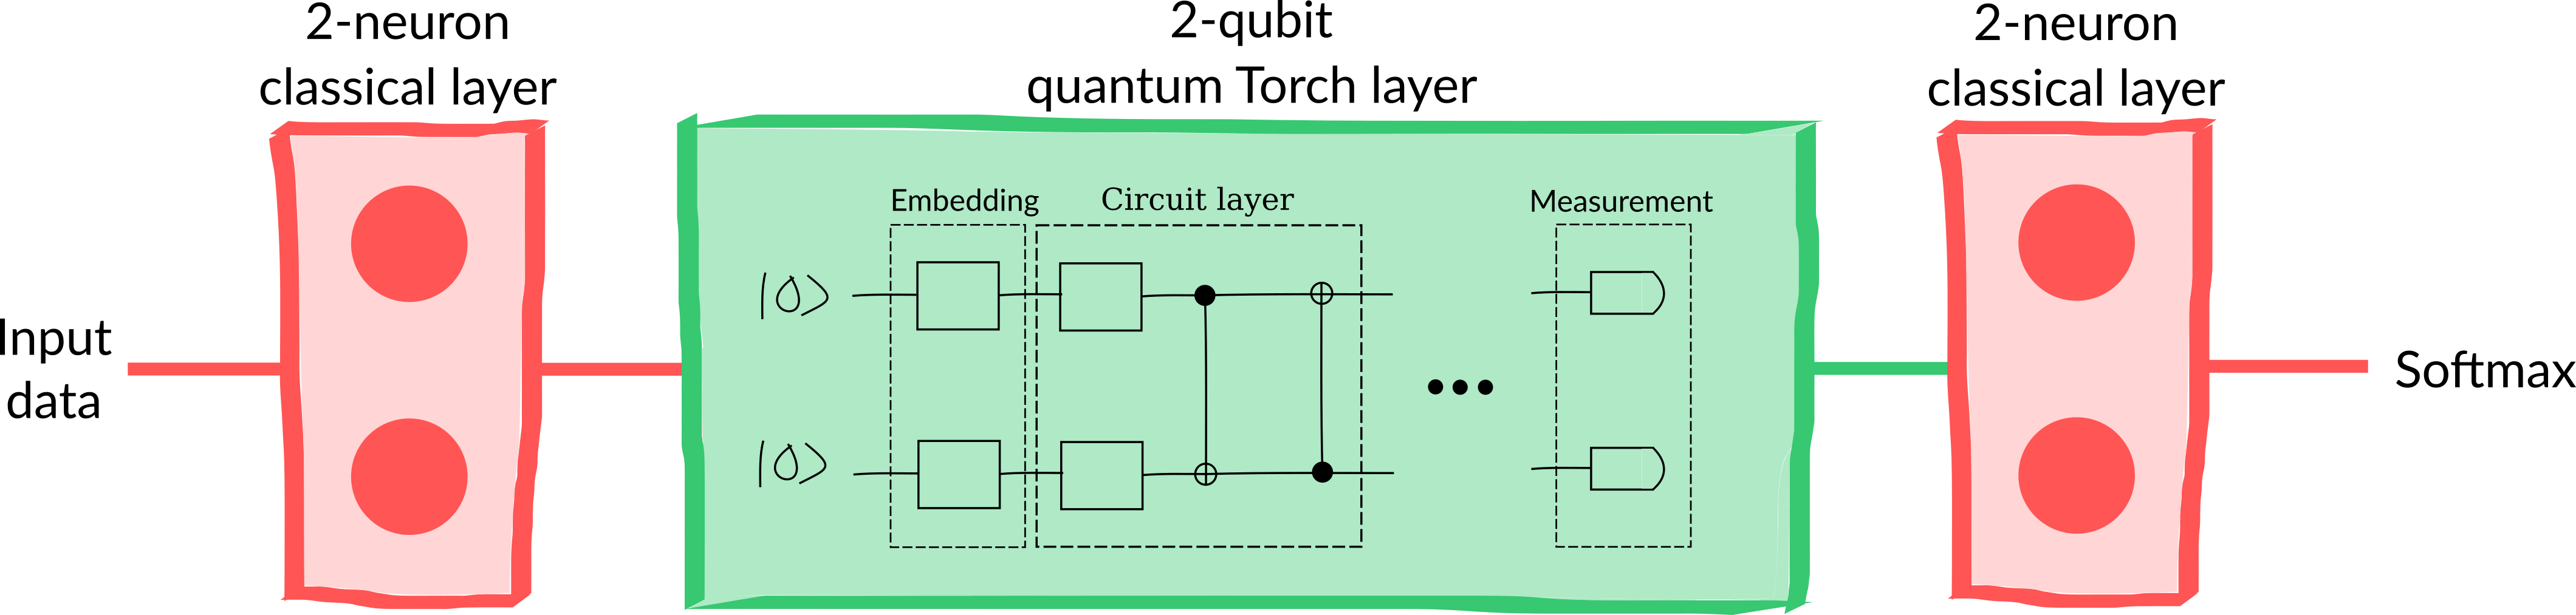


In [11]:
clayer_1 = torch.nn.Linear(2, 2)
clayer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

# Training the model

In [12]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

In [13]:
x = torch.tensor(x, requires_grad=True).float()
y_hot_torch = y_hot_torch.float()

In [14]:
batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(x, y_hot_torch)), batch_size=5, shuffle=True, drop_last=True
)

In [15]:
epochs = 6

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

Average loss over epoch 1: 0.4943
Average loss over epoch 2: 0.4226
Average loss over epoch 3: 0.2847
Average loss over epoch 4: 0.2121
Average loss over epoch 5: 0.1845
Average loss over epoch 6: 0.1666


In [16]:
y_pred = model(x)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 85.5%


# Creating non-sequential models

Suppose we want to make a hybrid model consisting of:

1. a 4-neuron fully connected classical layer
2. a 2-qubit quantum layer connected to the first two neurons of the previous classical layer
3. a 2-qubit quantum layer connected to the second two neurons of the previous classical layer
4. a 2-neuron fully connected classical layer which takes a 4-dimensional input from the combination of the previous quantum layers
5. a softmax activation to convert to a probability vector

A diagram of the model can be seen in the figure below.

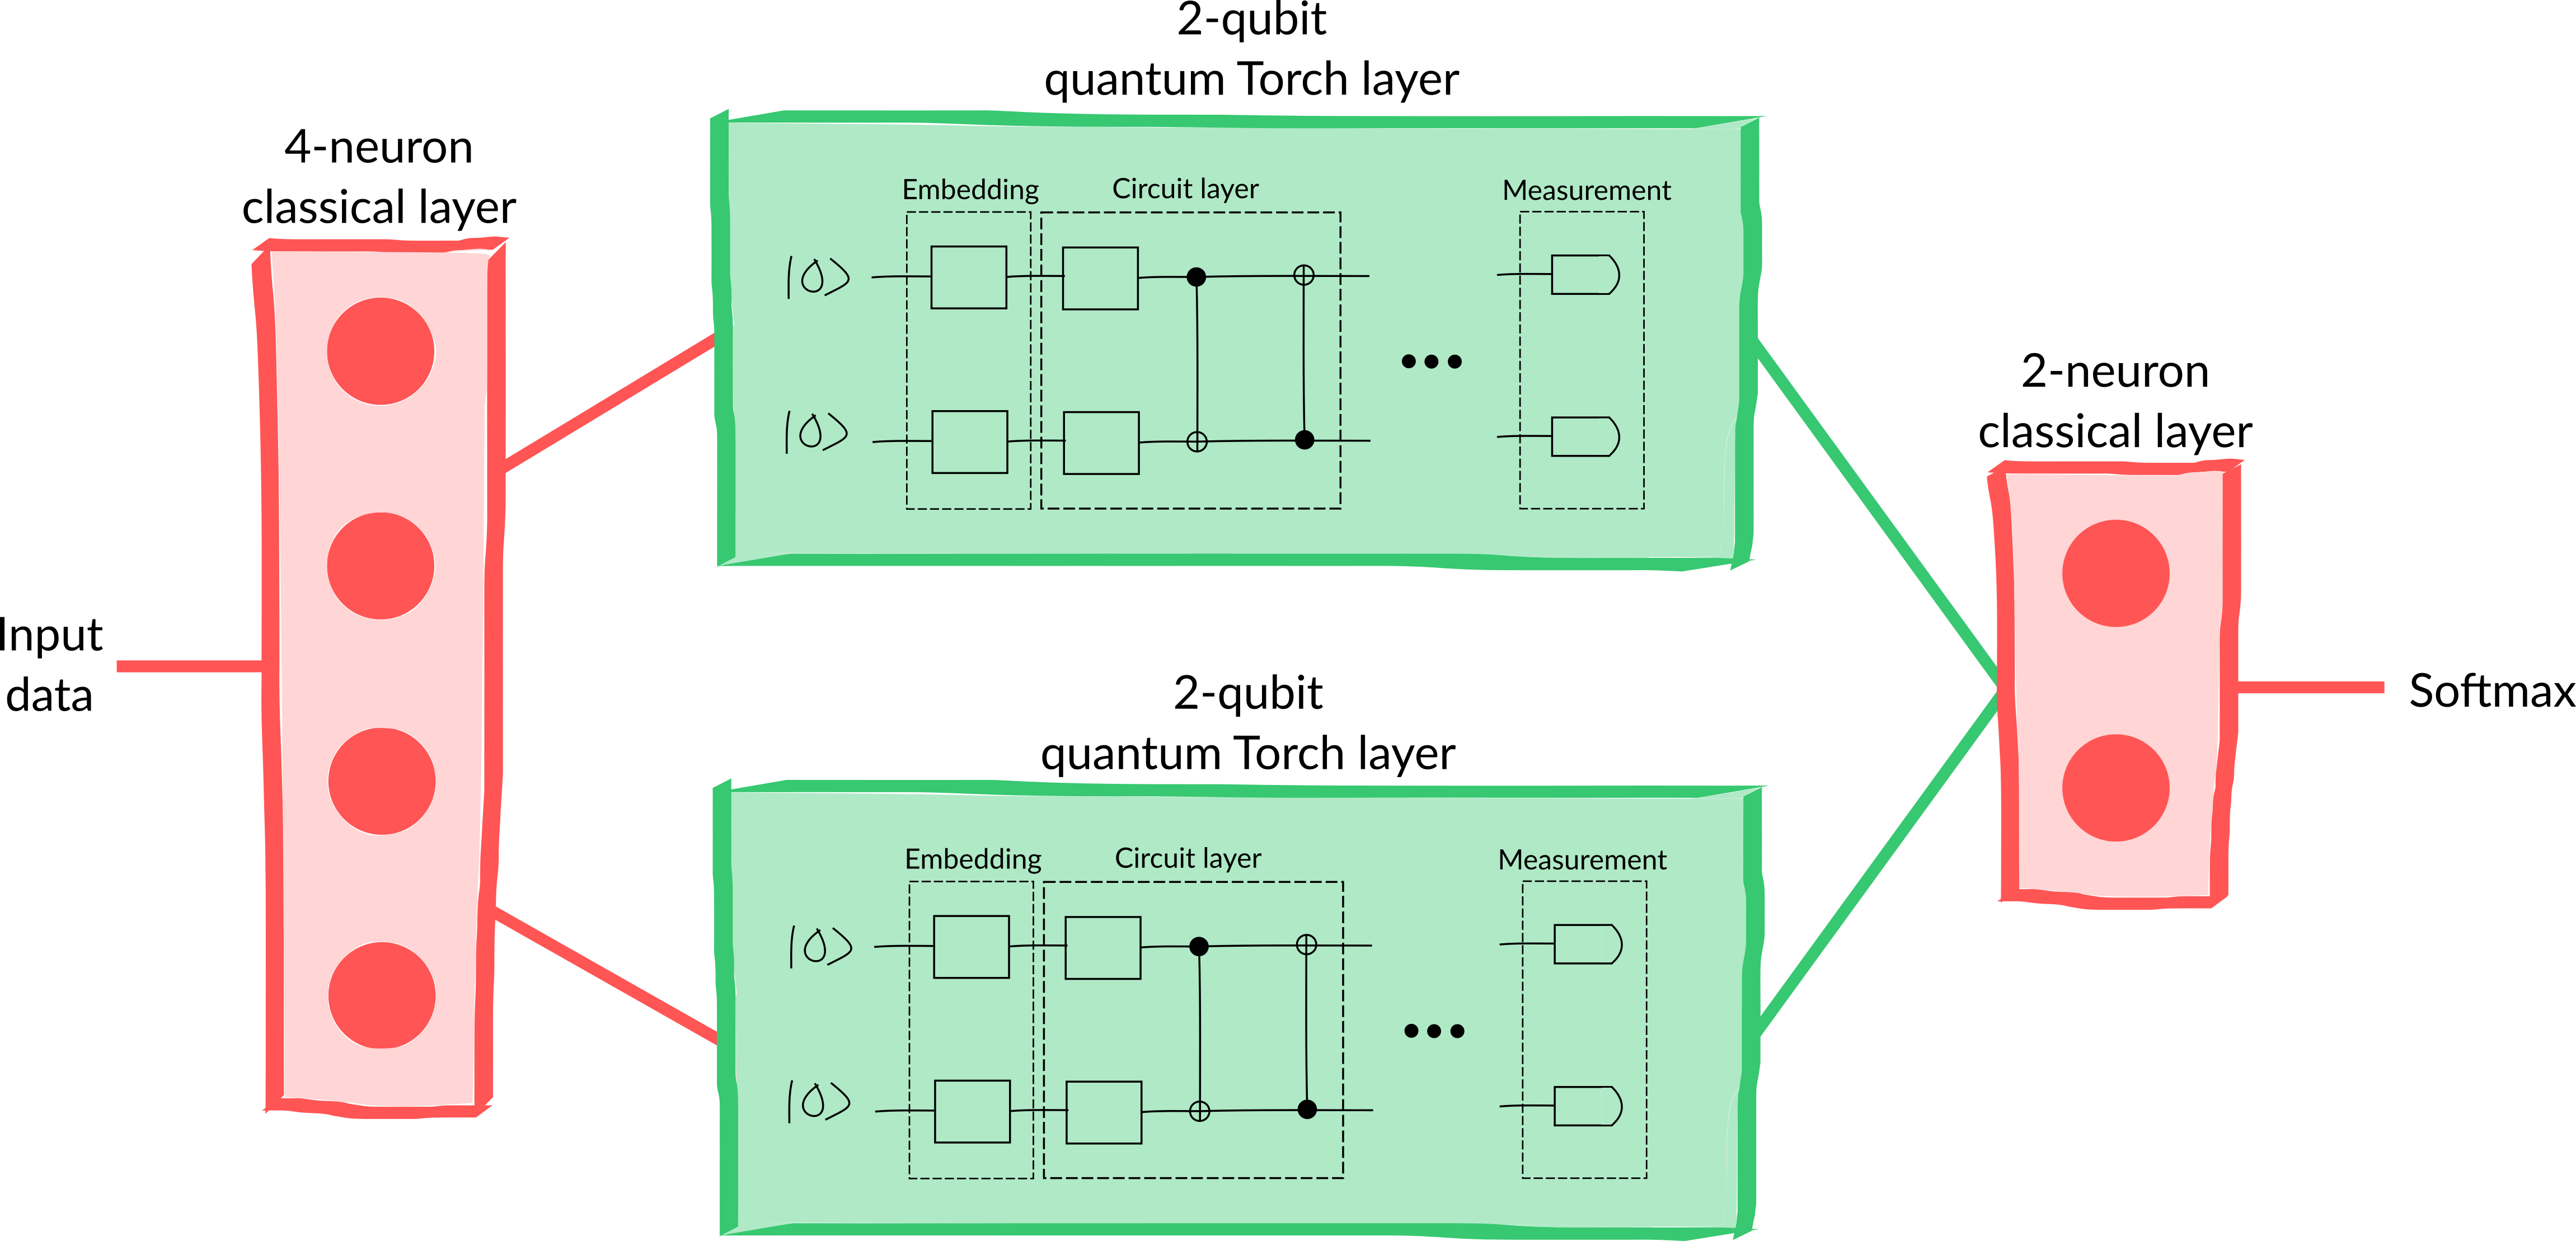

This model can also be constructed by creating a new class that inherits from the torch.nn Module and overriding the `forward()` method:

In [17]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 4)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(4, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 2, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

As a final step, let’s train the model to check if it’s working:

In [18]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
epochs = 6

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

Average loss over epoch 1: 0.4333
Average loss over epoch 2: 0.2811
Average loss over epoch 3: 0.2164
Average loss over epoch 4: 0.1909
Average loss over epoch 5: 0.1704
Average loss over epoch 6: 0.1639


In [19]:
y_pred = model(x)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 85.5%
